In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd 
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TransformerMixin
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Preprocessing

In [2]:
# expects a list of string
# return a list of tokenized words where numbers and stop words are removed-
def preprocessing(sentences):
    sentences_tokenized = []
    stopwords =['end', 'to', 'notprovided', 'ref', 'eur']
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = re.sub('[0-9]+', " ", sentence)
        tokens = re.findall(r'\w+', sentence)
        fin_tok = []
        for token in tokens:
            if len(token) > 1 and token not in stopwords:
                fin_tok.append(token)
        sentences_tokenized.append(fin_tok)
    return sentences_tokenized

In [3]:
# load data from csv into pandas dataFrame and convert them to list
transaction_df = pd.read_csv("Exercise 1 - Transaction Classification - Data Set.csv", sep=";")
y = transaction_df['label'].tolist()
Verwendungszweck = transaction_df['Verwendungszweck'].tolist()
Buchungstext = transaction_df['Buchungstext'].tolist()

# concat Buchungstext und Verwendungszweck
combinded_text = [Buchungstext[i] + " " + Verwendungszweck[i] for i in range(0,len(Verwendungszweck))]

# preprocess both feature sets
Verwendungszweck_transformed = preprocessing(Verwendungszweck)
combinded_text_transformed = preprocessing(combinded_text)

## Vectorizing and Modelling

In [4]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [5]:
# create pipelines
clf_MultinominalNB = Pipeline([('vect', TfidfVectorizer(analyzer=lambda x: x)), ('clf', MultinomialNB())])
clf_ComplementNB = Pipeline([('vect', TfidfVectorizer(analyzer=lambda x: x)), ('clf', ComplementNB())])
clf_GaussianNB = Pipeline([('vect', TfidfVectorizer(analyzer=lambda x: x)), ('to_dense', DenseTransformer()),
                           ('clf', GaussianNB())])

## Hyperparamter Tuning and K-fold Cross Validation

In [6]:
#set up paramters 
parameters = {'clf__alpha': (10, 2, 1, 1e-2, 1e-3, 1e-4, 1e-5), 
              'vect__ngram_range': [(1, 1), (1, 2)], 
              'vect__use_idf': (True, False)}

parameters_Gaus = {'vect__ngram_range': [(1, 1), (1, 2)], 
                   'vect__use_idf': (True, False)}

all_models = [('Multinominal',clf_MultinominalNB, parameters), 
              ('ComplementNB', clf_ComplementNB, parameters), 
              ('GaussianNB', clf_GaussianNB, parameters_Gaus)]

features = [('verwendungszweck', Verwendungszweck_transformed), 
            ('combined', combinded_text_transformed)]

scoring = ['accuracy', 'f1_macro']

In [7]:
# perform kfold corss validation
trained_models = [(str(name) + "_" + str(feature), GridSearchCV(model, parameter, 
                   cv=5, iid=False, scoring=scoring, refit='accuracy').fit(X, y)) 
                   for name, model, parameter in all_models 
                   for feature, X in features]

In [8]:
trained_models_results = []
for row in trained_models:
    for i in range(len(row[1].cv_results_['mean_test_accuracy'])):
        if row[1].cv_results_['rank_test_accuracy'][i] == 1:
            f1 = row[1].cv_results_['mean_test_f1_macro'][i]
            acc = row[1].cv_results_['mean_test_accuracy'][i]
    if str(row[0])[0:10] == "GaussianNB":
        trained_models_results.append([row[0], "-", acc, f1])
    else:
        trained_models_results.append([row[0], row[1].best_params_['clf__alpha'],acc, f1])

In [9]:
summary_df = pd.DataFrame(trained_models_results)
summary_df.columns = ['Model', 'best Paramters', 'Accuracy', 'F1-Score']
# summary_df.to_excel("models.xlsx")
summary_df

,Model,best Paramters,Accuracy,F1-Score
0,Multinominal_verwendungszweck,0.01,0.884132,0.852223
1,Multinominal_combined,0.01,0.893661,0.881755
2,ComplementNB_verwendungszweck,2,0.879010,0.847454
3,ComplementNB_combined,0.01,0.898539,0.887860
4,GaussianNB_verwendungszweck,-,0.893868,0.895313
5,GaussianNB_combined,-,0.898746,0.902269


## Evaluation

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,cmap=plt.cm.Blues):  
    title = 'Normalized confusion matrix'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title= title,
           ylabel = 'True label',
           xlabel = 'Predicted label')
    ax.set_xlabel('Predicted label', fontsize = 12)
    ax.set_ylabel('True label', fontsize = 12)
    ax.set_title(title, fontsize = 14)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('cm.png')
    return ax

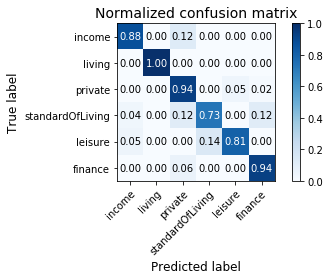

In [11]:
# Plot normalized confusion matrix
y_pred = y_pred = cross_val_predict(clf_ComplementNB, combinded_text_transformed, y, cv=5)
plot_confusion_matrix(y, y_pred, classes=transaction_df['label'].unique())
plt.show()